In [1]:
import pandas as pd
import random
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score

# Importing Data

In [2]:
data_train = pd.read_csv('Mushroom_datasets/mushroom_train.csv')
data_test = pd.read_csv('Mushroom_datasets/mushroom_test.csv')
data_train.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season,class
0,4.98,c,i,y,f,a,c,n,6.04,6.21,w,f,f,d,a,p
1,2.84,x,y,y,f,a,c,w,5.66,3.55,y,t,r,h,u,p
2,11.44,x,y,y,f,a,c,w,7.03,25.29,n,t,e,d,w,e
3,8.77,s,t,r,t,d,c,g,4.44,13.61,r,f,f,d,a,p
4,7.55,x,d,n,t,p,c,y,8.41,18.44,y,f,f,d,a,e


# Trival System

In [3]:
N = data_train.shape[0]
N1 = data_train[data_train['class']=='p'].shape[0]
N2 = data_train[data_train['class']=='e'].shape[0]
N_test = data_test['class'].shape[0]
y_pred = []

for _ in range(N_test):
    if random.random() < N1/N:
        y_pred.append('p')
    else:
        y_pred.append('e')

acc = 0
for i in range(N_test):
    if y_pred[i] == data_test['class'][i]:
        acc+=1
        
print("Accuracy of test dataset is", acc*100/N, "%")

Accuracy of test dataset is 21.748385889398335 %


In [4]:
f_score = f1_score(data_test['class'], y_pred, pos_label='e')
print("F1 score:", f_score)

F1 score: 0.4437869822485207


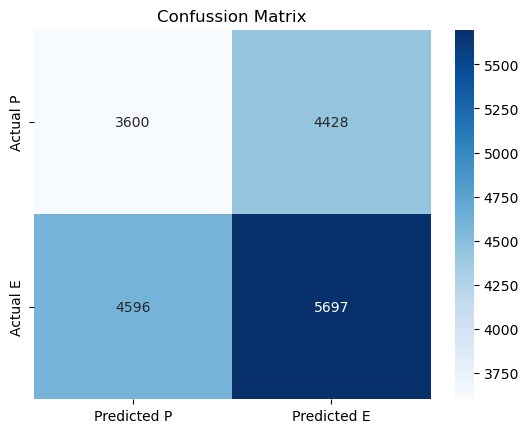

In [5]:
cm = confusion_matrix(data_test['class'], y_pred)
cm_df = pd.DataFrame(cm, index=['Actual P', 'Actual E'], columns=['Predicted P', 'Predicted E'])
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title("Confussion Matrix")
plt.show()

# One-Hot Encoding

In [6]:
classes = ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-color', 'has-ring', 'ring-type', 'habitat', 'season']
for i in classes:
    print("Unique values of", i, ':', data_train[i].unique())

temp_train = pd.get_dummies(data_train, columns=classes)
temp_test = pd.get_dummies(data_test, columns=classes)

Unique values of cap-shape : ['c' 'x' 's' 'o' 'f' 'b' 'p']
Unique values of cap-surface : ['i' 'y' 't' 'd' 'g' 'h' 'k' 's' 'e' 'w' 'l']
Unique values of cap-color : ['y' 'r' 'n' 'w' 'g' 'k' 'o' 'l' 'e' 'u' 'b' 'p']
Unique values of does-bruise-or-bleed : ['f' 't']
Unique values of gill-attachment : ['a' 'd' 'p' 'x' 'e' 'f' 's']
Unique values of gill-spacing : ['c' 'd' 'f']
Unique values of gill-color : ['n' 'w' 'g' 'y' 'p' 'k' 'f' 'b' 'e' 'o' 'r' 'u']
Unique values of stem-color : ['w' 'y' 'n' 'r' 'o' 'g' 'l' 'e' 'u' 'f' 'k' 'p' 'b']
Unique values of has-ring : ['f' 't']
Unique values of ring-type : ['f' 'r' 'e' 'z' 'l' 'p' 'g' 'm']
Unique values of habitat : ['d' 'h' 'g' 'l' 'm' 'w' 'p' 'u']
Unique values of season : ['a' 'u' 'w' 's']


# Baseline System

In [7]:
X_train = temp_train.drop('class', axis=1)
y_train = temp_train['class']
X_test = temp_test.drop('class', axis=1)
y_test = temp_test['class']
class_means = X_train.groupby(y_train).mean()
    
y_pred = []
class_labels = class_means.index.values
for i in range(len(X_test)):
    distances = []
    for j in range(len(class_means)):
        dist = euclidean(X_test.iloc[i], class_means.iloc[j])
        distances.append(dist)
    pred_idx = distances.index(min(distances))
    pred_label = class_labels[pred_idx]
    y_pred.append(pred_label)
    
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of test dataset:", accuracy*100, "%")

Accuracy of test dataset: 60.34605097975001 %


In [8]:
f_score = f1_score(y_test, y_pred, pos_label='e')
print("F1 score:", f_score)

F1 score: 0.5364639826453136


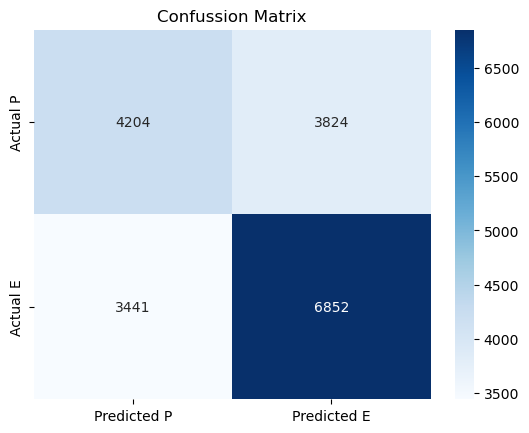

In [9]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual P', 'Actual E'], columns=['Predicted P', 'Predicted E'])
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title("Confussion Matrix")
plt.show()

# Using PCA feature engineering

Best decomposition value: 41
Best accuracy of test dataset: 69.7178101632007 %


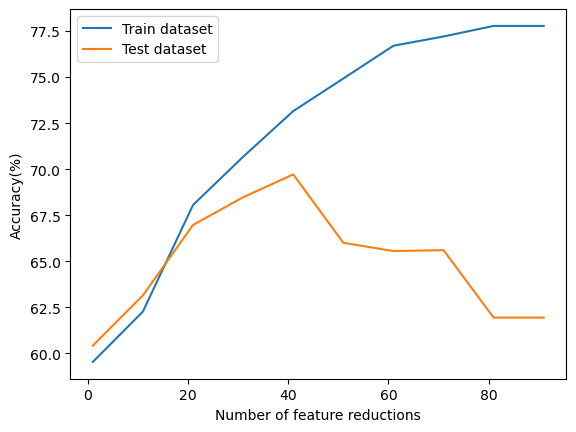

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

accuracy_train = []
accuracy_test = []
for i in range(1, 92, 10):
    pca = PCA(n_components=i)
    X_pca_train = pca.fit_transform(X_train)
    X_pca_test = pca.fit_transform(X_test)

    lr = LogisticRegression(max_iter=10000)
    lr.fit(X_pca_train, y_train)
    y_pred_train = lr.predict(X_pca_train)
    y_pred = lr.predict(X_pca_test)

    accuracy_train.append(accuracy_score(y_train, y_pred_train))
    accuracy_test.append(accuracy_score(y_test, y_pred))

print("Best decomposition value:", accuracy_test.index(max(accuracy_test))*10+1)
print("Best accuracy of test dataset:", max(accuracy_test)*100, "%")
plt.plot(range(1, 92, 10), np.array(accuracy_train)*100, label='Train dataset')
plt.plot(range(1, 92, 10), np.array(accuracy_test)*100, label='Test dataset')
plt.xlabel("Number of feature reductions")
plt.ylabel("Accuracy(%)")
plt.legend()
plt.show()

# Using FDA feature engineering

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

fld = LinearDiscriminantAnalysis(n_components=1)
fld.fit(X_train, y_train)

X_train_fld = fld.transform(X_train)
X_test_fld = fld.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train_fld, y_train)
y_pred = lr.predict(X_test_fld)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of test dataset:", accuracy*100, "%")

Accuracy of test dataset: 77.31564870913161 %


# Using UFS feature engineering

Best number of features to select: 51
Best feature set: Index(['cap-diameter', 'stem-height', 'stem-width', 'cap-shape_b',
       'cap-shape_f', 'cap-shape_o', 'cap-shape_p', 'cap-shape_x',
       'cap-surface_h', 'cap-surface_i', 'cap-surface_k', 'cap-surface_s',
       'cap-surface_y', 'cap-color_b', 'cap-color_e', 'cap-color_n',
       'cap-color_o', 'cap-color_p', 'cap-color_r', 'gill-attachment_a',
       'gill-attachment_d', 'gill-attachment_e', 'gill-attachment_p',
       'gill-spacing_c', 'gill-spacing_d', 'gill-color_b', 'gill-color_e',
       'gill-color_n', 'gill-color_w', 'stem-color_b', 'stem-color_e',
       'stem-color_f', 'stem-color_g', 'stem-color_k', 'stem-color_n',
       'stem-color_p', 'stem-color_r', 'stem-color_w', 'stem-color_y',
       'has-ring_f', 'has-ring_t', 'ring-type_l', 'ring-type_m', 'ring-type_z',
       'habitat_g', 'habitat_l', 'habitat_p', 'habitat_u', 'habitat_w',
       'season_s', 'season_w'],
      dtype='object')
Best accuracy of test dataset

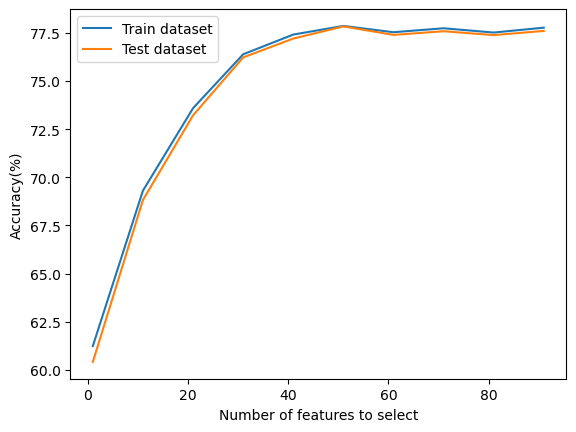

In [12]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import LabelEncoder

accuracy_train = []
accuracy_test = []
features_list = []
for i in range(1, 92, 10):
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y_train)
    y_t = label_encoder.fit_transform(y_test)

    best_select = SelectKBest(score_func=f_regression, k=i)
    best_select.fit(X_train, y)

    best_features = best_select.get_support(indices=True)
    features = X_train.columns[best_features]
    features_list.append(features)
    new_train = X_train[features]
    new_test = X_test[features]

    lr = LogisticRegression(max_iter=10000)
    lr.fit(new_train, y)
    y_pred_train = lr.predict(new_train)
    y_pred = lr.predict(new_test)

    accuracy_train.append(accuracy_score(y, y_pred_train))
    accuracy_test.append(accuracy_score(y_t, y_pred))

print("Best number of features to select:", len(features_list[accuracy_test.index(max(accuracy_test))]))
print("Best feature set:", features_list[accuracy_test.index(max(accuracy_test))])
print("Best accuracy of test dataset:", max(accuracy_test)*100, "%")
plt.plot(range(1, 92, 10), np.array(accuracy_train)*100, label='Train dataset')
plt.plot(range(1, 92, 10), np.array(accuracy_test)*100, label='Test dataset')
plt.xlabel("Number of features to select")
plt.ylabel("Accuracy(%)")
plt.legend()
plt.show()

# Using RFE feature engineering

Best number of features to select: 51
Best feature set: Index(['cap-shape_b', 'cap-shape_o', 'cap-surface_e', 'cap-surface_h',
       'cap-surface_i', 'cap-surface_k', 'cap-surface_l', 'cap-surface_s',
       'cap-surface_y', 'cap-color_b', 'cap-color_e', 'cap-color_k',
       'cap-color_l', 'cap-color_o', 'cap-color_r', 'cap-color_u',
       'gill-attachment_a', 'gill-attachment_d', 'gill-attachment_p',
       'gill-attachment_s', 'gill-attachment_x', 'gill-spacing_d',
       'gill-color_b', 'gill-color_e', 'gill-color_f', 'gill-color_n',
       'gill-color_u', 'gill-color_y', 'stem-color_b', 'stem-color_e',
       'stem-color_f', 'stem-color_g', 'stem-color_k', 'stem-color_l',
       'stem-color_o', 'stem-color_p', 'stem-color_w', 'ring-type_f',
       'ring-type_g', 'ring-type_m', 'ring-type_p', 'ring-type_r',
       'ring-type_z', 'habitat_g', 'habitat_p', 'habitat_u', 'habitat_w',
       'season_a', 'season_s', 'season_u', 'season_w'],
      dtype='object')
Number of features to s

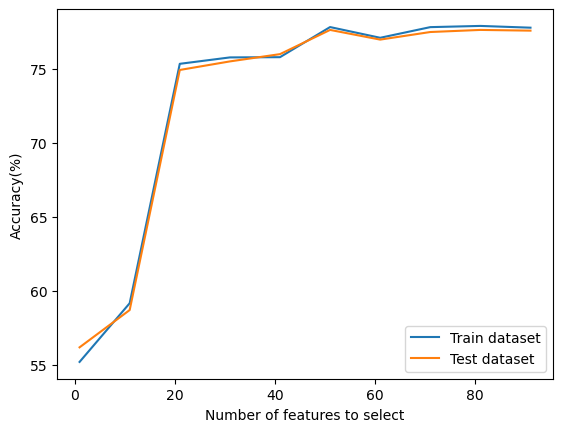

In [13]:
from sklearn.feature_selection import RFE

accuracy_train = []
accuracy_test = []
features_list = []
for i in range(1, 92, 10):
    lr = LogisticRegression(max_iter=10000)
    rfe = RFE(lr, n_features_to_select=i)
    fit = rfe.fit(X_train, y_train)
    best_features = X_train.columns[fit.support_]
    features_list.append(best_features)
    final_model = LogisticRegression(max_iter=10000).fit(X_train[best_features], y_train)
    y_pred_train = final_model.predict(X_train[best_features])
    y_pred = final_model.predict(X_test[best_features])
    
    accuracy_train.append(accuracy_score(y_train, y_pred_train))
    accuracy_test.append(accuracy_score(y_test, y_pred))
    
print("Best number of features to select:", len(features_list[accuracy_test.index(max(accuracy_test))]))
print("Best feature set:", features_list[accuracy_test.index(max(accuracy_test))])
print("Number of features to select:", best_features)
print("Best accuracy of test dataset:", max(accuracy_test)*100, "%")
plt.plot(range(1, 92, 10), np.array(accuracy_train)*100, label='Train dataset')
plt.plot(range(1, 92, 10), np.array(accuracy_test)*100, label='Test dataset')
plt.xlabel("Number of features to select")
plt.ylabel("Accuracy(%)")
plt.legend()
plt.show()

# Using SFE feature engineering

This took too much time to compute. mention a bit about this in report